In [2]:
# TODO:
# 1. Update bert 0.6.1 vs 0.4.0  See https://github.com/huggingface/pytorch-pretrained-BERT/issues/328
# 2. add crf on the top bert
# +3. calculate probability of a sequence
# 4. Try standard CRF with features from ACL paper
# 5. Try other dataset (CONLL-2003, OntoNotes 5.0, NLPBA (http://www.nactem.ac.uk/tsujii/GENIA/ERtask/report.html), BioCreative)
# +7. Draw plots for CAD, HYP, DIABETES
# +8. Try document-level annotations
# 9. Create Bi-LSTM CRF baseline using Flair       <================
# 10. Разобраться с тем как оценивали участники результаты на проверочном корпусе What is evaluated in i2b2 ? 

# 11. Take small amount of unannotated data, build dictionary and try to outperform the dictionary baseline
# 12. Show that language models are super cool for active learning since you can use just a shallow architecture for training (faster)
# 13. Just show that bert kills old baselines.
# 14. Unlexicalized BERT for active learning (Poked bert delex.py)
# 15. Propose a self-attention network for tagging and show it is better than LSTM
# + 16. New variants of ranking procedure. Most uncertain among those that get positive labels. Most uncertain among tokens that have positive labels. 
# (yeah it seems to work at some point)

# Calculate % of data by using number of tokens.
# Use dictionary-based procedure to generate first annotated dataset
# + Token evaluation metrics
# + Try BERT without fine tuning Работает так себе ~45% f1
# + evaluate bert on test data
# Посмотреть, как работают скрипты оценки качества в i2b2
# Fix sentence splitting procedure <===================
# Fine-tune bert model and train only classifier https://github.com/huggingface/pytorch-pretrained-BERT/tree/master/examples/lm_finetuning
# Fix performance issue: generate batch with the length of the biggest sentence in batch <=================
# + Implement early stopping on dev set 
# + Rerun all experiments with bert on new test data 
# + Fix AL pipeline: retrain model from scratch, etc. 
# Widget: implement updating of text field with selection in Javascript. Then activate text field and   catch callback in python
# + Check how we can deal with gpu memory allocation problem
# + Make charts to plot several strategies at once 
# Inclusive, exclusive evaluation.
# Measure time till convergence

# Vadim incorrect validation set need to take part of train instead of test
# Make conversion stage from i2b2 format into conll. Use conll2003 format as the primary for experiments

In [ ]:
!pip show pytorch-pretrained-bert

In [ ]:
!pip install seqeval

In [ ]:
!pip install pytorch-pretrained-bert==0.4.0

In [ ]:
!pip install git+https://github.com/IINemo/libact.git@seq

In [ ]:
#!pip install -e ./packages/libact/
!pip uninstall -y actleto
!pip install git+https://github.com/IINemo/active_learning_toolbox.git@seq

# Initialization

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import sys

#sys.path += ['./active_learning_toolbox/']

In [2]:
import torch

device = torch.device("cuda")
n_gpu = torch.cuda.device_count()

for i in range(n_gpu):
    print(torch.cuda.get_device_name(i))

Tesla V100-DGXS-16GB


In [3]:
import logging
logger = logging.getLogger('biomed_ie')

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

fhandler = logging.FileHandler(filename='../workdir/i2b2_active_learning.log', mode='a')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)

handler = logging.StreamHandler(sys.stdout)
handler.setFormatter(formatter)
logger.addHandler(handler)

logger.setLevel(logging.DEBUG)

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import json

# Global parameters

In [5]:
CACHE_DIR = '../workdir/models/0.4.0'

# MAX_LEN = 150
BATCH_SIZE = 40
MAX_LEN = 100
#BATCH_SIZE = 100
#BATCH_SIZE_PRED = 1200 # 1600
BATCH_SIZE_PRED = 1300 # 1600
random_state = 2019

# Load dataset

In [6]:
from i2b2_utils import drop_noise_samples, tokenize_and_generate_labels, split_train_test_by_document, create_tensors
from bert_utils import train, test, create_model_optimizer

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

from sklearn.model_selection import train_test_split

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [7]:
dataset_path = '../workdir/i2b2_training.json'
dataset = pd.read_json(dataset_path)
print(dataset.shape)
dataset.head()

(46635, 5)


,HYPERTENSION,CAD,DIABETES,texts,doc_ids
0,[],[],[],Record date: 2154-07-21\n\n\n\tCARDIOLOGY\n\t\...,0
1,[],[],[],D.,0
10,"[[24, 36]]",[],[],She has well-controlled hypertension on stable...,0
100,[],[],[],a.,1
1000,[],[],[],"SOCIAL HISTORY, FAMILY HISTORY, AND REVIEW OF ...",18


In [41]:
#attr_name = 'HYPERTENSION'
#attr_name = 'CAD'
attr_name = 'DIABETES'

selected_dataset = drop_noise_samples(dataset, attr_name)
selected_dataset.shape

(14183, 5)

In [42]:
n_notempty = selected_dataset[attr_name].apply(lambda l:len(l) != 0).sum()
n_notempty / selected_dataset.shape[0]

0.0731862088415709

In [ ]:
# CAD 0.03498688474000926
# Diabetes 0.0731862088415709
# Hypertension 0.13007800628102523

In [9]:
#train_selected_dataset, test_selected_dataset = split_train_test_by_document(selected_dataset, test_ratio=0.2)

In [8]:
dataset_test_path = '../workdir/i2b2_testing.json'
dataset_test = pd.read_json(dataset_test_path)
print(dataset_test.shape)
dataset_test.head()

(30208, 5)


,HYPERTENSION,CAD,DIABETES,texts,doc_ids
0,[],[],[],Record date: 2094-03-19\n\n\n\n \nInfectious D...,0
1,[],[],[],Consultation was requested by Dr.,0
10,[],[],[],Wound failed to improve.,0
100,[],[],[],Obstructive sleep apnea.,1
1000,[],[],[],Occlusion of the right femoral to popliteal PT...,17


In [15]:
test_selected_dataset = drop_noise_samples(dataset_test, attr_name)
train_selected_dataset = selected_dataset
print('train', selected_dataset.shape)
print('test', test_selected_dataset.shape)

train (25924, 5)
test (16560, 5)


# Prepare model and preprocessing

In [12]:
from isanlp.en.processor_tokenizer_nltk_en import ProcessorTokenizerNltkEn

word_tokenizer = ProcessorTokenizerNltkEn()
bpe_tokenizer = BertTokenizer.from_pretrained('bert-base-cased', cache_dir=CACHE_DIR, do_lower_case=False)
train_sents, train_labels = tokenize_and_generate_labels(word_tokenizer, bpe_tokenizer, train_selected_dataset, attr_name, MAX_LEN)
test_sents, test_labels = tokenize_and_generate_labels(word_tokenizer, bpe_tokenizer, test_selected_dataset, attr_name, MAX_LEN)

In [13]:
tags_vals = ['B', 'I', 'O', 'X', '[CLS]', '[SEP]']
tag2idx = {t : i for i, t in enumerate(tags_vals)}

In [14]:
train_input_ids, train_tags, train_attention_masks = create_tensors(bpe_tokenizer, tag2idx, 
                                                                    train_sents, train_labels, MAX_LEN)
test_input_ids, test_tags, test_attention_masks = create_tensors(bpe_tokenizer, tag2idx, 
                                                                 test_sents, test_labels, MAX_LEN)

# Training

In [14]:
from i2b2_utils import subsample_dataset

train_input_ids, train_tags, train_attention_masks = subsample_dataset(train_input_ids, train_tags, 
                                                                       train_attention_masks, 
                                                                       positive_tag=tag2idx['B'], 
                                                                       negative_ratio=0.1, positive_ratio=1.)

In [16]:
logger.info('Creating model...')
model, optimizer, lr_scheduler = create_model_optimizer(tag2idx, full_finetuning=True)
logger.info('Done.')

t_tr_inputs = torch.tensor(train_input_ids)
t_tr_tags = torch.tensor(train_tags)
t_tr_masks = torch.tensor(train_attention_masks)

t_val_inputs = torch.tensor(test_input_ids)
t_val_tags = torch.tensor(test_tags)
t_val_masks = torch.tensor(test_attention_masks)

train_data = TensorDataset(t_tr_inputs, t_tr_masks, t_tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(t_val_inputs, t_val_masks, t_val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE_PRED, shuffle=False)

train(model, optimizer, lr_scheduler, train_dataloader, valid_dataloader, 
      epochs=30, device=device, tags_vals=tags_vals, early_stopping=1)

2019-06-26 22:53:50,989 - biomed_ie - INFO - Creating model...
2019-06-26 22:54:01,233 - biomed_ie - INFO - Full finetuning: True
2019-06-26 22:54:01,237 - biomed_ie - INFO - N parameters: 108314886
2019-06-26 22:54:01,238 - biomed_ie - INFO - Done.



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-06-26 22:55:35,382 - biomed_ie - INFO - Train loss: 0.02435320077721963
2019-06-26 22:55:48,288 - biomed_ie - INFO - Validation loss: 0.0033637873296226773
2019-06-26 22:55:53,191 - biomed_ie - INFO - Validation F1-Score: 0.7223399745654938
2019-06-26 22:55:53,415 - biomed_ie - INFO - Validatin accuracy: 0.9989714881713092



Epoch:   3%|▎         | 1/30 [01:52<54:14, 112.23s/it]

2019-06-26 22:57:28,007 - biomed_ie - INFO - Train loss: 0.0032752441070634047
2019-06-26 22:57:40,824 - biomed_ie - INFO - Validation loss: 0.002912793674373201
2019-06-26 22:57:45,649 - biomed_ie - INFO - Validation F1-Score: 0.7314439946018894
2019-06-26 22:57:45,879 - biomed_ie - INFO - Validatin accuracy: 0.9990567950991974



Epoch:   7%|▋         | 2/30 [03:44<52:24, 112.30s/it]

2019-06-26 22:59:20,085 - biomed_ie - INFO - Train loss: 0.0021721922756667857
2019-06-26 22:59:32,873 - biomed_ie - INFO - Validation loss: 0.0029465519889656988
2019-06-26 22:59:37,736 - biomed_ie - INFO - Validation F1-Score: 0.7422590492804187
2019-06-26 22:59:37,962 - biomed_ie - INFO - Validatin accuracy: 0.9990761098753231


# Active learning

In [9]:
from actleto import ActiveLearner, make_libact_strategy_ctor
from libact.query_strategies import UncertaintySampling, RandomSampling
from active_learning_seq import LibActNN, f1_score_wrapper, RandomSamplingWithRetraining, LibActNNPositiveLessCertain


def initialize_seeds(train_input_ids, train_tags, tags_vals, n_seeds_per_class=10):
    indexes = np.array(range(train_tags.shape[0]))
    known_indexes = []
    for label in range(len(tags_vals)):
        selected_indices = indexes[(train_tags == label).astype('float').sum(axis=1) != 0]
        known_indexes += list(np.random.choice(selected_indices, size=n_seeds_per_class))

    known_indexes = list(set(known_indexes))
    logger.info(f'Number of seeding examples: {len(known_indexes)}')
    tags_seed = [None for _ in range(train_tags.shape[0])]

    for i in known_indexes:
        tags_seed[i] = train_tags[i]

    Y_seed = tags_seed
    X_train = train_input_ids
    
    return X_train, Y_seed
    

def create_active_learner(X_train, Y_seed, 
                          X_test, y_test, 
                          tags_vals,
                          libact_model, 
                          ranking_strategy,
                          rnd_steps=0):
    max_samples_number = 20
    random_state = 42

    active_learn_alg_ctor = make_libact_strategy_ctor(lambda tr_ds: ranking_strategy(tr_ds, libact_model), 
                                                      max_samples_number=max_samples_number)
    
    def _f1_score(a,b):
        return f1_score_wrapper(tags_vals, a,b)

    # Creating ActiveLearning object that implements AL logic.
    active_learner = ActiveLearner(active_learn_alg_ctor = active_learn_alg_ctor,
                                   y_dtype = 'int',
                                   X_full_dataset = X_train, 
                                   y_full_dataset = Y_seed,
                                   X_test_dataset = X_test,
                                   y_test_dataset = y_test,
                                   model_evaluate=libact_model,
                                   eval_metrics=[_f1_score],
                                   rnd_start_steps=rnd_steps, 
                                   rnd_start_samples=max_samples_number)
    
    return active_learner


def emulate_active_learning(train_tags, 
                            active_learner, 
                            max_iterations=12, 
                            n_annotations_per_iter=20):
    logger.info('Start emulating active learning.')
    active_learner.start()
    logger.info(f'Evaluation: {active_learner.evaluate(fit_model=False)}')

    statistics = []
    for i in range(max_iterations):
        logger.info(f'Active learning iteration: #{i}')
        samples_to_annotate = active_learner.choose_samples_for_annotation()
        active_learner.make_iteration(samples_to_annotate, train_tags[samples_to_annotate])
        perf = active_learner.evaluate(fit_model=False)
        statistics.append(perf)
        logger.info(f'Performance: {perf}')
    
    return statistics

## Perform single emulation of AL

In [15]:
model, optimizer, lr_scheduler = create_model_optimizer(tag2idx)
libact_model = LibActNN(model, optimizer, lr_scheduler, device=device, batch_size=BATCH_SIZE)

2019-06-18 16:10:55,560 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): s3.amazonaws.com:443
2019-06-18 16:10:58,010 - urllib3.connectionpool - DEBUG - https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-base-cased.tar.gz HTTP/1.1" 200 0
2019-06-18 16:10:58,016 - pytorch_pretrained_bert.modeling - INFO - loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased.tar.gz from cache at ../workdir/models/0.4.0/a803ce83ca27fecf74c355673c434e51c265fb8a3e0e57ac62a80e38ba98d384.681017f415dfb33ec8d0e04fe51a619f3f01532ecea04edbfd48c5d160550d9c
2019-06-18 16:10:58,020 - pytorch_pretrained_bert.modeling - INFO - extracting archive file ../workdir/models/0.4.0/a803ce83ca27fecf74c355673c434e51c265fb8a3e0e57ac62a80e38ba98d384.681017f415dfb33ec8d0e04fe51a619f3f01532ecea04edbfd48c5d160550d9c to temp dir /tmp/tmp0a1a46hf
2019-06-18 16:11:05,066 - pytorch_pretrained_bert.modeling - INFO - Model config {
  "attention_probs_dropout_prob": 

In [16]:
np.random.seed(42)

In [17]:
X_train, Y_seed = initialize_seeds(train_input_ids, train_tags, tags_vals)

60


In [ ]:
ranking_strategy = lambda trn_ds, libact_model: UncertaintySampling(trn_ds, model=libact_model, method='lc')
#ranking_strategy = lambda trn_ds, libact_model: RandomSamplingWithRetraining(trn_ds, libact_model)

active_learner = create_active_learner(X_train, Y_seed, test_input_ids, test_tags, tags_vals, 
                                       libact_model=libact_model, ranking_strategy=ranking_strategy, rnd_steps=1)

In [ ]:
statistics = emulate_active_learning(active_learner)

In [96]:
import json

statistics_path = '../workdir/statistics_us.json'
#statistics_path = '../workdir/statistics_random.json'

with open(statistics_path, 'w') as f:
    json.dump(statistics, f)

In [97]:
with open('../workdir/statistics_us.json', 'r') as f:
    statistics_us = json.load(f)
    
with open('../workdir/statistics_random.json', 'r') as f:
    statistics_random = json.load(f)

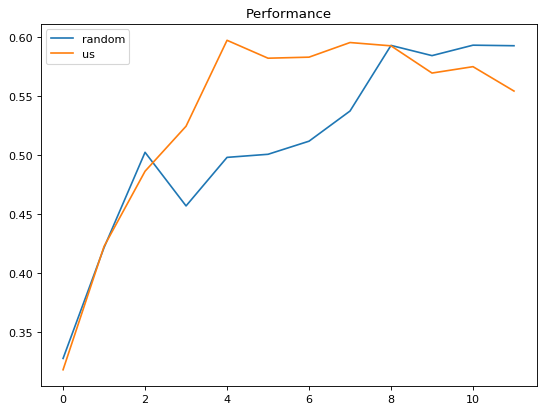

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline 

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt1, = plt.plot(list(range(len(statistics))), [e['_f1_score'] for e in statistics_random], label='random')
plt2, = plt.plot(list(range(len(statistics_us))), [e['_f1_score'] for e in statistics_us], label='us')
plt.legend(handles=[plt1, plt2])
plt.title('Performance')
plt.show()

## Multiple AL evaluations

In [10]:
def perform_several_al_passes(train_input_ids, train_tags, 
                              test_input_ids, test_tags, 
                              tags_vals, tag2index, 
                              ranking_strategy, fit_model, 
                              n_passes, n_al_iterations):
    stats = []
    for i in range(n_passes):
        logger.info('=============== Pass: {} ============='.format(i))
        
        np.random.seed(42 + i*3)
        
#         libact_model = LibActNN(model_ctor=(lambda : create_model_optimizer(tag2index)),
#                                 device=device, 
#                                 batch_size=BATCH_SIZE,
#                                 bs_pred=BATCH_SIZE_PRED,
#                                 train_from_scratch=True,
#                                 retrain_epochs=17,
#                                 early_stopping=4)
        
        libact_model = LibActNNPositiveLessCertain(
            tag2index['B'],
            model_ctor=(lambda : create_model_optimizer(tag2index)), 
            device=device, 
            batch_size=BATCH_SIZE,
            bs_pred=BATCH_SIZE_PRED,
            train_from_scratch=True,
            retrain_epochs=17,
            early_stopping=4
        )

        X_train, Y_seed = initialize_seeds(train_input_ids, train_tags, tags_vals)
        active_learner = create_active_learner(X_train, Y_seed, test_input_ids, test_tags, 
                                               tags_vals, libact_model, 
                                               ranking_strategy=ranking_strategy)
        
        statistics = emulate_active_learning(train_tags, 
                                             active_learner, 
                                             max_iterations=n_al_iterations)
        stats.append(statistics)
    
    return stats

In [ ]:
#ranking_strategy = lambda trn_ds, libact_model: RandomSamplingWithRetraining(trn_ds, model=libact_model)
ranking_strategy = lambda trn_ds, libact_model: UncertaintySampling(trn_ds, model=libact_model, method='lc')
stats = perform_several_al_passes(ranking_strategy)

### Run exp

In [11]:
def run_experiment_al(train_dataset,
                      test_dataset,
                      attr_name, 
                      word_tokenizer, 
                      bpe_tokenizer,
                      output_file_path,
                      n_passes=10,
                      n_al_iterations=25):
    logger.info('Preparing data...')
    
    train_selected_dataset = drop_noise_samples(train_dataset, attr_name)
    test_selected_dataset = drop_noise_samples(test_dataset, attr_name)
    #train_selected_dataset, test_selected_dataset = split_train_test_by_document(selected_dataset, test_ratio=0.2)
    train_sents, train_labels = tokenize_and_generate_labels(word_tokenizer, bpe_tokenizer, 
                                                             train_selected_dataset, attr_name, MAX_LEN)
    test_sents, test_labels = tokenize_and_generate_labels(word_tokenizer, bpe_tokenizer, 
                                                           test_selected_dataset, attr_name, MAX_LEN)
    
    tags_vals = ['B', 'I', 'O', 'X', '[CLS]', '[SEP]']
    tag2idx = {t : i for i, t in enumerate(tags_vals)}
    
    train_input_ids, train_tags, train_attention_masks = create_tensors(bpe_tokenizer, tag2idx, 
                                                                        train_sents, train_labels, MAX_LEN)
    test_input_ids, test_tags, test_attention_masks = create_tensors(bpe_tokenizer, tag2idx, 
                                                                     test_sents, test_labels, MAX_LEN)
    
    logger.info('Done.')
    
    logger.info('=======================Active learning with uncertainty sampling ======================')
    
    ranking_strategy = lambda trn_ds, _libact_model: UncertaintySampling(trn_ds, model=_libact_model, method='lc')
    stats = perform_several_al_passes(train_input_ids, train_tags, 
                                      test_input_ids, test_tags, 
                                      tags_vals, tag2idx, 
                                      ranking_strategy=ranking_strategy, 
                                      fit_model=False, 
                                      n_passes=n_passes,
                                      n_al_iterations=n_al_iterations)
    stats = np.array([[e['_f1_score'] for e in series] for series in stats ])
    np.save(os.path.join(output_file_path, '{}_us.npy'.format(attr_name.lower())), stats)
    
    logger.info('Done with uncertainty sampling.')
    
    logger.info('=======================Active learning with random sampling ============================')
    
    ranking_strategy = lambda trn_ds, _libact_model: RandomSamplingWithRetraining(trn_ds, model=_libact_model, method='lc')
    stats = perform_several_al_passes(train_input_ids, train_tags, 
                                      test_input_ids, test_tags, 
                                      tags_vals, tag2idx, 
                                      ranking_strategy=ranking_strategy, 
                                      fit_model=False,
                                      n_passes=n_passes,
                                     n_al_iterations=n_al_iterations)
    stats = np.array([[e['_f1_score'] for e in series] for series in stats ])
    np.save(os.path.join(output_file_path, '{}_random.npy'.format(attr_name.lower())), stats)
    
    logger.info('Done.')

In [1]:
from isanlp.en.processor_tokenizer_nltk_en import ProcessorTokenizerNltkEn

word_tokenizer = ProcessorTokenizerNltkEn()
bpe_tokenizer = BertTokenizer.from_pretrained('bert-base-cased', cache_dir=CACHE_DIR, do_lower_case=False)
run_experiment_al(dataset, dataset_test, 'DIABETES', word_tokenizer, bpe_tokenizer, 
                  output_file_path='../workdir/experiments_5/')

NameError: name 'BertTokenizer' is not defined

### Charts

In [24]:
from itertools import cycle

from matplotlib import pyplot as plt
#from matplotlib.pyplot import figure
%matplotlib inline 


def generate_plot(np_stats, color_bg, color_line, marker, label):
    disp = np_stats.std(axis=0)
    means = np_stats.mean(axis=0)

    x = list(range(1, means.shape[0] + 1))

    plt.fill_between(x, means - disp, means + disp, color=color_bg, alpha=0.5)
    plt.xticks(range(1, means.shape[0] + 2, 2))
    return plt.plot(x, means, color=color_line, label=label, marker=marker)


def create_chart(expert_dir, attr_type, save_dir=None):
    fig = plt.figure(num=None, figsize=(8, 6), 
                     dpi=100, facecolor='w', edgecolor='k')
    plt_list = []
    
    color_pool = cycle([('red', 'darksalmon', 'o'), 
                        ('midnightblue', 'skyblue', 'v'), 
                        ('g', 'lightgreen', 's'), 
                        ('gold', 'palegoldenrod', '*')])
    
    for filename in sorted(os.listdir(expert_dir)):
        noext = os.path.splitext(filename)[0]
        if '_' not in noext:
            continue
            
        f_type, f_strat = noext.split('_')
        
        if f_type != attr_type:
            continue
        
        color = next(color_pool)
        file_path = os.path.join(expert_dir, filename)
        stats = np.load(file_path)
        chart, = generate_plot(stats, 
                               color_bg=color[1], 
                               color_line=color[0], 
                               marker=color[2],
                               label=f_strat)
        plt_list.append(chart)
        
    plt.legend(handles=plt_list, loc='lower right', fontsize='x-large')
    plt.ylabel('Performance, F1', fontdict={'size' : 15})
    plt.xlabel('AL iteration, #', fontdict={'size' : 15})
    plt.tick_params(labelsize=12)
    
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, f'{attr_type}.png'))
        
    plt.show()

#### Single chart

In [11]:
us_stats = np.load('../workdir/experiments/hypertension_us.npy')
random_stats = np.load('../workdir/experiments/hypertension_random.npy')

In [ ]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt1, = generate_plot(random_stats, color_bg='skyblue', color_line='midnightblue', label='random')
plt2, = generate_plot(us_stats, color_bg='darksalmon', color_line='red', label='US')

plt.legend(handles=[plt1, plt2])
plt.ylabel('Performance, F1')
plt.xlabel('AL iteration, #')
plt.show()

#### Multiple charts

In [17]:
# def create_chart(exper_dir, attr_type):
#     us_stats = np.load(os.path.join(exper_dir, f'{attr_type}_us.npy'))
#     random_stats = np.load(os.path.join(exper_dir, f'{attr_type}_random.npy'))
    
#     figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

#     plt1, = generate_plot(random_stats, color_bg='skyblue', color_line='midnightblue', label='random')
#     plt2, = generate_plot(us_stats, color_bg='darksalmon', color_line='red', label='US')

#     plt.legend(handles=[plt1, plt2])
#     plt.ylabel('Performance, F1')
#     plt.xlabel('AL iteration, #')
#     plt.show()

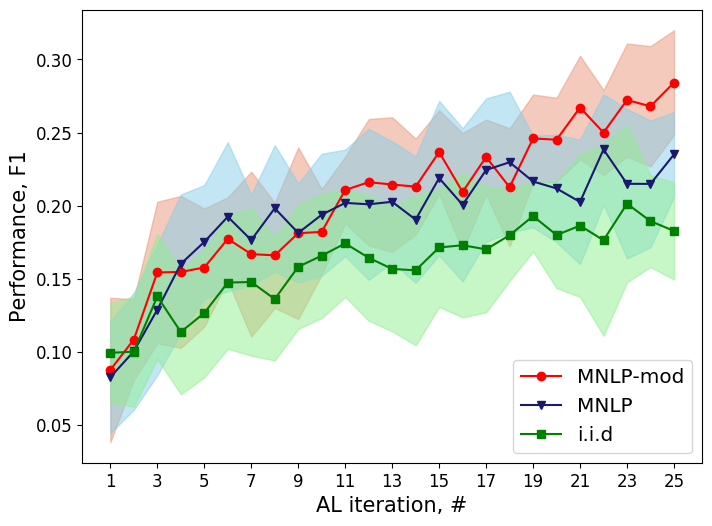

In [25]:
create_chart('../workdir/experiments_draw/', 'cad', save_dir='./')

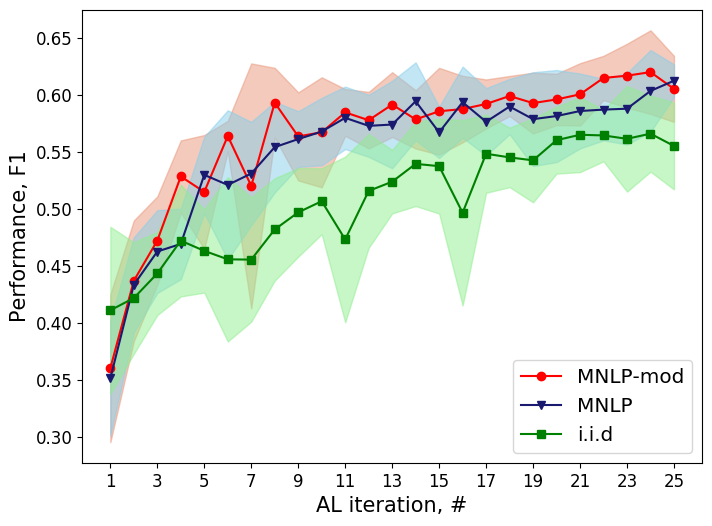

In [26]:
create_chart('../workdir/experiments_draw/', 'hypertension', save_dir='./')

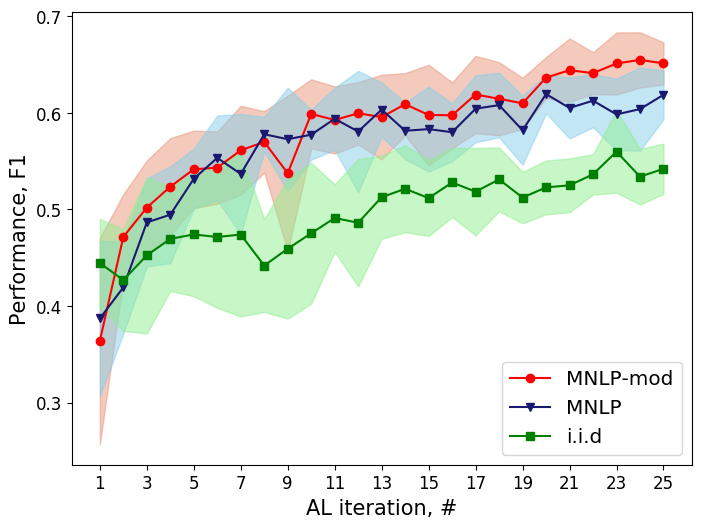

In [27]:
create_chart('../workdir/experiments_draw/', 'diabetes', save_dir='./')

In [17]:
import numpy as np


def print_al_stats(data_path, entire_dat_score):
    stats = np.load(data_path)
    print(stats[:,-1].shape)
    al_score = stats[:,-1].mean()
    score_ratio = al_score / entire_dat_score
    print('Al score: ', al_score)
    print('Entire data score:', entire_dat_score)
    print('Score ratio:', score_ratio)

In [18]:
data_path = '../workdir/experiments_draw/diabetes_MNLP-mod.npy'
entire_dat_score = 0.718
print_al_stats(data_path, entire_dat_score)

(10,)
Al score:  0.6513872668796481
Entire data score: 0.718
Score ratio: 0.9072246056819612


In [19]:
data_path = '../workdir/experiments_draw/cad_MNLP-mod.npy'
entire_dat_score = 0.401
print_al_stats(data_path, entire_dat_score)

(10,)
Al score:  0.2841254596866301
Entire data score: 0.401
Score ratio: 0.708542293482868


In [20]:
data_path = '../workdir/experiments_draw/hypertension_MNLP-mod.npy'
entire_dat_score = 0.739
print_al_stats(data_path, entire_dat_score)

(10,)
Al score:  0.6053099221998488
Entire data score: 0.739
Score ratio: 0.8190932641405261


In [ ]:
import numpy as np

data_path = '../workdir/experiments_draw/diabetes_MNLP-mod.npy'
stats = np.load(data_path)

stats.mean()